# 1.데이터 준비

## 기본 환경설정

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings(action='ignore')

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'

## 파일 준비하기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/머신러닝/ASAC project/모델링/train.csv')
train_ori = pd.read_csv('/content/drive/MyDrive/머신러닝/ASAC project/모델링/WA_Fn-UseC_-HR-Employee-Attrition.csv')
test = pd.read_csv('/content/drive/MyDrive/머신러닝/ASAC project/모델링/test.csv')

# concat 전에 원본 데이터의 타겟 변수 수치형으로 변환
train_ori.Attrition = train_ori.Attrition.apply(lambda x:1 if x=='Yes' else 0)

# 원본, train, test 데이터 병합
df = pd.concat([train, train_ori, test])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4266 entries, 0 to 1118
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2796 non-null   float64
 1   Age                       4266 non-null   int64  
 2   BusinessTravel            4266 non-null   object 
 3   DailyRate                 4266 non-null   int64  
 4   Department                4266 non-null   object 
 5   DistanceFromHome          4266 non-null   int64  
 6   Education                 4266 non-null   int64  
 7   EducationField            4266 non-null   object 
 8   EmployeeCount             4266 non-null   int64  
 9   EnvironmentSatisfaction   4266 non-null   int64  
 10  Gender                    4266 non-null   object 
 11  HourlyRate                4266 non-null   int64  
 12  JobInvolvement            4266 non-null   int64  
 13  JobLevel                  4266 non-null   int64  
 14  JobRole 

In [ ]:
df.shape

(4266, 36)

In [ ]:
df.nunique()

id                          2796
Age                           43
BusinessTravel                 3
DailyRate                    909
Department                     3
DistanceFromHome              29
Education                      6
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        5
Gender                         2
HourlyRate                    71
JobInvolvement                 5
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1415
MonthlyRate                 1467
NumCompaniesWorked            11
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               5
TotalWorkingYears             41
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

# 2.전처리

## 피처 제거

In [ ]:
# 의미없는 변수 제거 : id, Over18, StandardHours, EmployeeCount, EmployeeNumber
df = df.drop(columns=['Over18', 'id', 'StandardHours','EmployeeCount', 'EmployeeNumber'])
df.head()


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,2,1,10,2,3,10,0,7,8,0.0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,4,1,4,3,3,4,2,0,3,0.0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,4,2,4,3,3,3,2,1,2,0.0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,3,Female,40,...,3,0,15,1,1,6,0,0,2,0.0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,3,0,31,0,3,31,14,4,10,1.0


In [ ]:
# # 서로 비슷한 의미를 가지고 있는 피처 삭제하기
# df = df.drop(['JobLevel','YearsInCurrentRole', 'YearsWithCurrManager' ], axis=1)

## 노이즈 제거

In [ ]:
# 아래 과정을 오류/노이즈라고 지정함

# 1. 나이 < 총 근무기간
# 2. 18세 미만 근무
# 3. 총 근무기간 < 현 회사 근무기간
# 4. 총 근무기간 < 현 직무 근무기간
# 5. 교육수준 > 5 (1~5가 정상)
# 6. 총 근무기간과 현 회사 근무기간이 다르면서 근무한 회사 수가 0일 때

age_error = df[df['Age'] < df['TotalWorkingYears']]
age_real_error = df[df['Age']-18 < df['TotalWorkingYears']]
working_yr_error = df[df["TotalWorkingYears"] < df["YearsAtCompany"]]
role_yr_error  = df[ df["TotalWorkingYears"] < df["YearsInCurrentRole"]]
edu_error = df[ df ["Education"] > 5]
num_comp_error = df [ (df["NumCompaniesWorked"]== 0 ) & (df["TotalWorkingYears"] != df["YearsAtCompany"])]


# 노이즈 데이터 합치기 (494개 -> 중복되는 데이터 제거하면 482개)
noise = pd.concat([age_error, age_real_error, working_yr_error, role_yr_error, edu_error, num_comp_error]).drop_duplicates()

In [ ]:
# 모델 학습에 사용하고자 하는 파일 (여기서 예시로 df)에서 노이즈 제거하기
# df에 noise 추가하면 노이즈에 해당하는 값은 두개씩 생긴다 -> 중복된다 -> 중복값 제거함수 사용해서 제거하기

df = pd.concat([df, noise]).drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3602 entries, 0 to 1118
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       3602 non-null   int64  
 1   BusinessTravel            3602 non-null   object 
 2   DailyRate                 3602 non-null   int64  
 3   Department                3602 non-null   object 
 4   DistanceFromHome          3602 non-null   int64  
 5   Education                 3602 non-null   int64  
 6   EducationField            3602 non-null   object 
 7   EnvironmentSatisfaction   3602 non-null   int64  
 8   Gender                    3602 non-null   object 
 9   HourlyRate                3602 non-null   int64  
 10  JobInvolvement            3602 non-null   int64  
 11  JobLevel                  3602 non-null   int64  
 12  JobRole                   3602 non-null   object 
 13  JobSatisfaction           3602 non-null   int64  
 14  MaritalS

In [ ]:
df.shape

(3602, 31)

# 3.피쳐엔지니어링

## 3.1 수치형 변수 정규화(Normalization)

In [ ]:
df.shape

(3602, 31)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_col = [
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

for col in df_col:
    df[col] = df[col].astype(float)
    df[[col]] = scaler.fit_transform(df[[col]])

df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,0.130139,Research & Development,0.821429,0.50,Medical,1.00,Male,0.171429,...,0.333333,0.25,0.250,0.333333,0.666667,0.250,0.000000,0.466667,0.470588,0.0
1,35,Travel_Rarely,0.214454,Sales,0.250000,0.50,Other,0.25,Male,0.228571,...,1.000000,0.25,0.100,0.500000,0.666667,0.100,0.111111,0.000000,0.176471,0.0
3,38,Travel_Rarely,0.362922,Research & Development,0.035714,0.50,Medical,0.75,Female,0.142857,...,0.666667,0.00,0.375,0.166667,0.000000,0.150,0.000000,0.000000,0.117647,0.0
4,50,Travel_Rarely,0.239592,Research & Development,0.142857,0.75,Medical,0.50,Female,0.100000,...,0.666667,0.00,0.775,0.000000,0.666667,0.775,0.777778,0.266667,0.588235,1.0
5,27,Travel_Rarely,0.121498,Research & Development,0.035714,0.50,Other,0.75,Female,0.371429,...,1.000000,0.00,0.150,0.000000,0.666667,0.025,0.000000,0.066667,0.000000,0.0


## 3.2 인코딩

### Label인코딩

In [ ]:
df.nunique()

Age                           43
BusinessTravel                 3
DailyRate                    881
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EnvironmentSatisfaction        5
Gender                         2
HourlyRate                    71
JobInvolvement                 5
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1357
MonthlyRate                 1402
NumCompaniesWorked            11
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StockOptionLevel               5
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                36
YearsInCurrentRole            19
YearsSinceLastPromotion       16
YearsWithCurrManager          18
Attrition 

In [ ]:
df.MaritalStatus

0        Married
1        Married
3        Married
4         Single
5         Single
          ...   
1113      Single
1114    Divorced
1115     Married
1116     Married
1118     Married
Name: MaritalStatus, Length: 3602, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# 고유값 수가 작거나, 순서에 영향을 미치는 컬럼 레이블 인코딩
df['BusinessTravel'] = encoder.fit_transform(df['BusinessTravel'])
df['Gender'] = encoder.fit_transform(df['Gender'])
df['OverTime'] = encoder.fit_transform(df['OverTime'])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,1,0.130139,Research & Development,0.821429,0.50,Medical,1.00,1,0.171429,...,0.333333,0.25,0.250,0.333333,0.666667,0.250,0.000000,0.466667,0.470588,0.0
1,35,2,0.214454,Sales,0.250000,0.50,Other,0.25,1,0.228571,...,1.000000,0.25,0.100,0.500000,0.666667,0.100,0.111111,0.000000,0.176471,0.0
3,38,2,0.362922,Research & Development,0.035714,0.50,Medical,0.75,0,0.142857,...,0.666667,0.00,0.375,0.166667,0.000000,0.150,0.000000,0.000000,0.117647,0.0
4,50,2,0.239592,Research & Development,0.142857,0.75,Medical,0.50,0,0.100000,...,0.666667,0.00,0.775,0.000000,0.666667,0.775,0.777778,0.266667,0.588235,1.0
5,27,2,0.121498,Research & Development,0.035714,0.50,Other,0.75,0,0.371429,...,1.000000,0.00,0.150,0.000000,0.666667,0.025,0.000000,0.066667,0.000000,0.0


### one-hot인코딩
- 인코딩할 명목형 변수 : 'Department', 'EducationField', 'JobRole', 'MaritalStatus'
- 인코딩 후 원래 변수 삭제

In [ ]:
# 명목형 데이터는 원-핫 인코딩 진행
from sklearn.preprocessing import OneHotEncoder

# onehotencoder 선언
encoder = OneHotEncoder()

# 명목형 변수 추리기
categories = df[['Department', 'EducationField', 'JobRole', 'MaritalStatus']]

# 인코딩된 새로운 df생성
encoded_categories = encoder.fit_transform(categories)
encoded_df = pd.DataFrame(encoded_categories.toarray(), columns=encoder.get_feature_names_out(categories.columns))
encoded_df

,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3598,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3600,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.shape, encoded_df.shape

((3602, 31), (3602, 21))

In [ ]:
# 원본 데이터에 인코딩 데이터 붙이기
df = df.reset_index()
encoded_df = encoded_df.reset_index()
con_df=pd.concat([df, encoded_df],axis=1)

# 기존 명목변수 drop
df = con_df.drop(columns=['Department', 'EducationField', 'JobRole', 'MaritalStatus','index'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                3602 non-null   int64  
 1   BusinessTravel                     3602 non-null   int64  
 2   DailyRate                          3602 non-null   float64
 3   DistanceFromHome                   3602 non-null   float64
 4   Education                          3602 non-null   float64
 5   EnvironmentSatisfaction            3602 non-null   float64
 6   Gender                             3602 non-null   int64  
 7   HourlyRate                         3602 non-null   float64
 8   JobInvolvement                     3602 non-null   float64
 9   JobLevel                           3602 non-null   float64
 10  JobSatisfaction                    3602 non-null   float64
 11  MonthlyIncome                      3602 non-null   float

In [ ]:
df.shape

(3602, 48)

In [ ]:
# 타겟 데이터 가장 마지막으로 이동
response = df['Attrition']
df= df.drop(labels=['Attrition'], axis=1)

df.insert(47,'Attrition', response)

df.head()

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition
0,36,1,0.130139,0.821429,0.50,1.00,1,0.171429,0.75,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,35,2,0.214454,0.250000,0.50,0.25,1,0.228571,0.75,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,38,2,0.362922,0.035714,0.50,0.75,0,0.142857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50,2,0.239592,0.142857,0.75,0.50,0,0.100000,0.75,0.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,27,2,0.121498,0.035714,0.50,0.75,0,0.371429,0.75,0.166667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3.3 train, test 데이터 분할

In [ ]:
# train과 test(대회용 데이터 분리(종속변수x)

# null이 아닌 것(타겟 데이터 포함)
train = df[~pd.isnull(df['Attrition'])]

# null인 것(타겟 데이터 미포함)
kaggle_test = df[pd.isnull(df['Attrition'])]
train.shape, kaggle_test.shape

((2665, 48), (937, 48))

In [ ]:
# target값 분리
y = train['Attrition']

# shape 맞추기
# train = train.drop(['Attrition'], axis=1)
kaggle_test = kaggle_test.drop(['Attrition'], axis=1)

train.shape, y.shape, kaggle_test.shape

((2665, 48), (2665,), (937, 47))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, :-1], train.iloc[:, -1:], test_size=0.2, stratify=y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2132, 47), (533, 47), (2132, 1), (533, 1))

# 4.모델 학습

## 후보 모델 선정 - 파이캐럿

### 버전 관리

In [ ]:
!pip install -q pycaret==3.0.4

In [ ]:
!pip install -q catboost

In [ ]:
!pip install -q xgboost==1.7.6

In [ ]:
!pip uninstall scipy
!pip install scipy==1.10.1

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scipy-1.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/scipy/*
Proceed (Y/n)? Y
  Successfully uninstalled scipy-1.10.1
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)


In [ ]:
import scipy
scipy.__version__
# 1.10.1

'1.10.1'

In [ ]:
import pycaret
pycaret.__version__
# 3.0.4

'3.0.4'

In [ ]:
import xgboost
xgboost.__version__
# 1.7.6

'1.7.6'

In [ ]:
import catboost
catboost.__version__
# 1.2.2

'1.2.2'

In [ ]:
import sklearn
sklearn.__version__
# 1.0.2

'1.2.2'

### setup

In [ ]:
X = pd.concat([X_train, y_train], axis=1)
X.shape

(2132, 48)

In [ ]:
# 분류용 모든 모둘
from pycaret.classification import *

In [ ]:
X.columns[-1]

'Attrition'

In [ ]:
clf = setup(data        = X, # 데이터 => df로 공급
      target            = X.columns[-1], # X 데이터 중 어떤 컬럼이 답인지, 컬럼명
      verbose           = True, # 로그 출력
      train_size        = 0.8, # 내부적으로 검증 시 훈련 데이터의 비율
      data_split_shuffle= True, # 데이터를 섞을 것인가?
      normalize         = True, # 정규화 처리 진행
      session_id        = 100 # 난수 시드
      )

,Description,Value
0,Session id,100
1,Target,Attrition
2,Target type,Binary
3,Original data shape,"(2132, 48)"
4,Transformed data shape,"(2132, 48)"
5,Transformed train set shape,"(1705, 48)"
6,Transformed test set shape,"(427, 48)"
7,Numeric features,47
8,Preprocess,True
9,Imputation type,simple


### 후보 모델 리스트업

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
top_5_model = compare_models(fold=5, round=3, sort='Accuracy', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.874,0.815,0.223,0.748,0.343,0.294,0.362,4.014
gbc,Gradient Boosting Classifier,0.873,0.799,0.259,0.685,0.373,0.319,0.367,1.418
lightgbm,Light Gradient Boosting Machine,0.871,0.784,0.263,0.664,0.374,0.317,0.361,0.648
ada,Ada Boost Classifier,0.869,0.790,0.323,0.601,0.417,0.351,0.374,1.578
lda,Linear Discriminant Analysis,0.869,0.812,0.299,0.620,0.400,0.337,0.367,0.260
lr,Logistic Regression,0.865,0.807,0.259,0.612,0.361,0.298,0.335,1.270
rf,Random Forest Classifier,0.863,0.810,0.124,0.737,0.210,0.174,0.262,1.220
xgboost,Extreme Gradient Boosting,0.863,0.786,0.251,0.597,0.351,0.288,0.323,1.012
et,Extra Trees Classifier,0.860,0.788,0.156,0.610,0.246,0.198,0.256,2.024
ridge,Ridge Classifier,0.859,0.000,0.100,0.640,0.172,0.138,0.212,0.180


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

In [ ]:
# 상위 5개 확인
top_5_model

 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=100, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=100, reg_alpha=0.0, reg_lamb

### 블랜딩

In [ ]:
blended = blend_models(estimator_list = top_5_model,
             fold           = 10,        # 폴드를 더 올렷음
             method         = 'hard',    # hard(다수결), soft(합산평균 확률)
             optimize       = 'Accuracy' # 정확도로 랭킹 산출, 판단 지표
             )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.0000,0.3200,0.8000,0.4571,0.4077,0.4612
1,0.8596,0.0000,0.1600,0.5714,0.2500,0.1988,0.2487
2,0.8596,0.0000,0.2400,0.5455,0.3333,0.2679,0.2963
3,0.8421,0.0000,0.1200,0.3750,0.1818,0.1194,0.1435
4,0.8713,0.0000,0.2308,0.7500,0.3529,0.3031,0.3689
5,0.8765,0.0000,0.3200,0.6667,0.4324,0.3726,0.4043
6,0.9118,0.0000,0.4400,0.9167,0.5946,0.5518,0.5989
7,0.8882,0.0000,0.3200,0.8000,0.4571,0.4073,0.4609
8,0.8588,0.0000,0.1600,0.5714,0.2500,0.1984,0.2483


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 최종 모델 추출 : catboost, lightgbm, lda, ada, gb

In [ ]:
model = finalize_model( blended )
model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Age', 'BusinessTravel',
                                             'DailyRate', 'DistanceFromHome',
                                             'Education',
                                             'EnvironmentSatisfaction',
                                             'Gender', 'HourlyRate',
                                             'JobInvolvement', 'JobLevel',
                                             'JobSatisfaction', 'MonthlyIncome',
                                             'MonthlyRate',
                                             'NumCompaniesWorked', 'OverTime',
                                             'PercentSa...
                                                                  base_estimator='deprecated',
                                                                  estimator=None,
                                                                  learning_rate=1.0,
                                                                  n_estimators=50,
                                                                  random_state=100)),
                                              ('Linear Discriminant Analysis',
                                               LinearDiscriminantAnalysis(covariance_estimator=None,
                                                                          n_components=None,
                                                                          priors=None,
                                                                          shrinkage=None,
                                                                          solver='svd',
                                                                          store_covariance=False,
                                                                          tol=0.0001))],
                                  flatten_transform=True, n_jobs=-1,
                                  verbose=False, voting='hard',
                                  weights=None))],
         verbose=False)

### 예측

In [ ]:
y_pred = predict_model( model, data=X_test )
y_pred.head(2)

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,prediction_label
270,36,2,0.162346,0.285714,0.5,0.75,1,0.071429,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
98,45,2,0.094789,0.535714,0.5,0.50,1,0.285714,0.75,0.500000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy_score( y_test.Attrition, y_pred.prediction_label )

0.8874296435272045

### 모델 생성

In [ ]:
# 데이터가 많으면 오래 걸리므로, 후보군을 미리 선전해서 진행
model_lgbm = create_model('lightgbm', fold=5)
model_catboost = create_model('catboost', fold=5)
model_lda  = create_model('lda', fold=5)
model_ada = create_model('ada', fold=5)
model_gbc  = create_model('gbc', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8768,0.7812,0.2400,0.7500,0.3636,0.3149,0.3785
1,0.8534,0.7790,0.2400,0.5000,0.3243,0.2533,0.2749
2,0.8680,0.7959,0.2800,0.6087,0.3836,0.3208,0.3513
3,0.8886,0.8019,0.3400,0.7727,0.4722,0.4203,0.4648
4,0.8680,0.7627,0.2157,0.6875,0.3284,0.2767,0.3347
Mean,0.8710,0.7842,0.2631,0.6638,0.3744,0.3172,0.3608
Std,0.0116,0.0138,0.0436,0.0997,0.0537,0.0572,0.0621


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8710,0.8361,0.2000,0.7143,0.3125,0.2654,0.3320
1,0.8563,0.7926,0.1800,0.5294,0.2687,0.2099,0.2479
2,0.8768,0.8118,0.2600,0.7222,0.3824,0.3304,0.3841
3,0.8886,0.8439,0.2600,0.9286,0.4062,0.3656,0.4574
4,0.8768,0.7929,0.2157,0.8462,0.3438,0.3013,0.3889
Mean,0.8739,0.8154,0.2231,0.7481,0.3427,0.2945,0.3621
Std,0.0105,0.0214,0.0322,0.1355,0.0490,0.0537,0.0696


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8768,0.8068,0.2800,0.7000,0.4000,0.3451,0.3905
1,0.8504,0.7997,0.2200,0.4783,0.3014,0.2302,0.2521
2,0.8768,0.8013,0.3200,0.6667,0.4324,0.3728,0.4045
3,0.8827,0.8604,0.3200,0.7273,0.4444,0.3898,0.4311
4,0.8563,0.7895,0.3529,0.5294,0.4235,0.3452,0.3544
Mean,0.8686,0.8115,0.2986,0.6203,0.4004,0.3366,0.3665
Std,0.0128,0.0251,0.0456,0.0984,0.0516,0.0558,0.0623


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8622,0.7989,0.2800,0.5600,0.3733,0.3054,0.3287
1,0.8563,0.7698,0.3200,0.5161,0.3951,0.3186,0.3303
2,0.8651,0.7714,0.2400,0.6000,0.3429,0.2828,0.3199
3,0.8886,0.8137,0.4000,0.7143,0.5128,0.4555,0.4800
4,0.8710,0.7985,0.3725,0.6129,0.4634,0.3950,0.4108
Mean,0.8686,0.7905,0.3225,0.6007,0.4175,0.3515,0.3739
Std,0.0110,0.0171,0.0585,0.0661,0.0620,0.0642,0.0624


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8651,0.8104,0.2200,0.6111,0.3235,0.2666,0.3100
1,0.8592,0.7826,0.2200,0.5500,0.3143,0.2516,0.2846
2,0.8739,0.7990,0.2800,0.6667,0.3944,0.3368,0.3766
3,0.8974,0.8226,0.3800,0.8261,0.5205,0.4717,0.5166
4,0.8710,0.7802,0.1961,0.7692,0.3125,0.2680,0.3459
Mean,0.8733,0.7990,0.2592,0.6846,0.3730,0.3190,0.3667
Std,0.0130,0.0162,0.0665,0.1010,0.0797,0.0819,0.0812


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#### 튜닝

In [ ]:
tune_model_lgbm = tune_model(model_lgbm, fold=5, optimize='AUC', choose_better=True)
tune_model_catboost = tune_model(model_catboost, fold=5, optimize='AUC', choose_better=True)
tune_model_lda  = tune_model(model_lda,      fold=5, optimize='AUC', choose_better=True)
tune_model_ada = tune_model(model_ada,  fold=5, optimize='AUC', choose_better=True)
tune_model_gbc      = tune_model(model_gbc,      fold=5, optimize='AUC', choose_better=True)

candidate_models = [
    tune_model_lgbm,
    tune_model_catboost,
    tune_model_lda,
    tune_model_ada,
    tune_model_gbc
]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8680,0.8243,0.2200,0.6471,0.3284,0.2744,0.3241
1,0.8680,0.7817,0.2800,0.6087,0.3836,0.3208,0.3513
2,0.8798,0.8443,0.3400,0.6800,0.4533,0.3941,0.4241
3,0.9032,0.8533,0.4200,0.8400,0.5600,0.5123,0.5513
4,0.8710,0.7898,0.2745,0.6667,0.3889,0.3305,0.3714
Mean,0.8780,0.8187,0.3069,0.6885,0.4228,0.3664,0.4044
Std,0.0133,0.0286,0.0681,0.0795,0.0792,0.0823,0.0804


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8886,0.8438,0.3600,0.7500,0.4865,0.4325,0.4693
1,0.8680,0.8137,0.3200,0.5926,0.4156,0.3486,0.3697
2,0.8680,0.8353,0.3200,0.5926,0.4156,0.3486,0.3697
3,0.8915,0.8671,0.3800,0.7600,0.5067,0.4532,0.4877
4,0.8710,0.8098,0.3137,0.6400,0.4211,0.3579,0.3868
Mean,0.8774,0.8339,0.3387,0.6670,0.4491,0.3882,0.4166
Std,0.0104,0.0209,0.0264,0.0739,0.0394,0.0453,0.0512


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8768,0.8069,0.2800,0.7000,0.4000,0.3451,0.3905
1,0.8534,0.7995,0.2200,0.5000,0.3056,0.2372,0.2623
2,0.8739,0.8047,0.3000,0.6522,0.4110,0.3510,0.3844
3,0.8827,0.8577,0.3200,0.7273,0.4444,0.3898,0.4311
4,0.8563,0.7909,0.3529,0.5294,0.4235,0.3452,0.3544
Mean,0.8686,0.8120,0.2946,0.6218,0.3969,0.3337,0.3645
Std,0.0116,0.0235,0.0444,0.0911,0.0480,0.0510,0.0566


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8827,0.8260,0.2800,0.7778,0.4118,0.3623,0.4212
1,0.8651,0.8197,0.2600,0.5909,0.3611,0.2982,0.3298
2,0.8622,0.7860,0.2000,0.5882,0.2985,0.2421,0.2860
3,0.8944,0.8381,0.3400,0.8500,0.4857,0.4387,0.4963
4,0.8680,0.8082,0.2157,0.6875,0.3284,0.2767,0.3347
Mean,0.8745,0.8156,0.2591,0.6989,0.3771,0.3236,0.3736
Std,0.0122,0.0177,0.0497,0.1030,0.0660,0.0696,0.0754


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8563,0.8231,0.0200,1.0000,0.0392,0.0337,0.1308
1,0.8592,0.7931,0.0800,0.6667,0.1429,0.1151,0.1967
2,0.8563,0.8092,0.0400,0.6667,0.0755,0.0599,0.1385
3,0.8592,0.8720,0.0400,1.0000,0.0769,0.0664,0.1853
4,0.8592,0.7968,0.0588,1.0000,0.1111,0.0961,0.2247
Mean,0.8581,0.8188,0.0478,0.8667,0.0891,0.0742,0.1752
Std,0.0014,0.0286,0.0203,0.1633,0.0352,0.0285,0.0356


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


#### 검증 모델 : catboost > ada > lda > lgbm > gb

In [ ]:
for tune_model in candidate_models:
    display(predict_model(tune_model))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8618,0.8141,0.3016,0.5588,0.3918,0.3216,0.3411


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition,prediction_label,prediction_score
844,25,1,0.139303,0.857143,0.25,1.00,1,0.442857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.9544
1132,30,2,0.314480,0.000000,1.00,0.50,0,0.500000,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.7214
2045,36,2,0.205027,0.535714,0.75,0.75,0,0.185714,1.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8683
1727,43,2,0.230427,0.392857,0.50,0.25,1,0.414286,0.50,0.500000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.9920
552,50,2,0.258968,0.035714,0.50,0.50,1,0.700000,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,28,2,0.206337,0.035714,0.75,0.75,1,0.228571,0.75,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8188
785,28,1,0.108143,0.357143,0.50,0.25,1,0.342857,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.9585
256,40,1,0.340927,0.000000,1.00,0.25,1,0.414286,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.7979
908,37,2,0.188269,0.321429,0.50,0.25,1,0.742857,0.50,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.6835


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8970,0.8658,0.3968,0.8065,0.5319,0.4815,0.5198


,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition,prediction_label,prediction_score
844,25,1,0.139303,0.857143,0.25,1.00,1,0.442857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.7660
1132,30,2,0.314480,0.000000,1.00,0.50,0,0.500000,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.8842
2045,36,2,0.205027,0.535714,0.75,0.75,0,0.185714,1.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8167
1727,43,2,0.230427,0.392857,0.50,0.25,1,0.414286,0.50,0.500000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.9807
552,50,2,0.258968,0.035714,0.50,0.50,1,0.700000,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,28,2,0.206337,0.035714,0.75,0.75,1,0.228571,0.75,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8559
785,28,1,0.108143,0.357143,0.50,0.25,1,0.342857,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.9073
256,40,1,0.340927,0.000000,1.00,0.25,1,0.414286,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9524
908,37,2,0.188269,0.321429,0.50,0.25,1,0.742857,0.50,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.5739


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8689,0.8386,0.3175,0.6061,0.4167,0.3508,0.3742


,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition,prediction_label,prediction_score
844,25,1,0.139303,0.857143,0.25,1.00,1,0.442857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.5508
1132,30,2,0.314480,0.000000,1.00,0.50,0,0.500000,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.9094
2045,36,2,0.205027,0.535714,0.75,0.75,0,0.185714,1.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8890
1727,43,2,0.230427,0.392857,0.50,0.25,1,0.414286,0.50,0.500000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.9804
552,50,2,0.258968,0.035714,0.50,0.50,1,0.700000,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,28,2,0.206337,0.035714,0.75,0.75,1,0.228571,0.75,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8897
785,28,1,0.108143,0.357143,0.50,0.25,1,0.342857,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.9184
256,40,1,0.340927,0.000000,1.00,0.25,1,0.414286,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9658
908,37,2,0.188269,0.321429,0.50,0.25,1,0.742857,0.50,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.7476


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8876,0.8537,0.3333,0.7778,0.4667,0.4149,0.4617


,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition,prediction_label,prediction_score
844,25,1,0.139303,0.857143,0.25,1.00,1,0.442857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.5063
1132,30,2,0.314480,0.000000,1.00,0.50,0,0.500000,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.5130
2045,36,2,0.205027,0.535714,0.75,0.75,0,0.185714,1.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.5525
1727,43,2,0.230427,0.392857,0.50,0.25,1,0.414286,0.50,0.500000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.5260
552,50,2,0.258968,0.035714,0.50,0.50,1,0.700000,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.5269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,28,2,0.206337,0.035714,0.75,0.75,1,0.228571,0.75,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.5130
785,28,1,0.108143,0.357143,0.50,0.25,1,0.342857,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.5182
256,40,1,0.340927,0.000000,1.00,0.25,1,0.414286,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.5204
908,37,2,0.188269,0.321429,0.50,0.25,1,0.742857,0.50,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.5023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8571,0.8657,0.0476,0.7500,0.0896,0.0732,0.1652


,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition,prediction_label,prediction_score
844,25,1,0.139303,0.857143,0.25,1.00,1,0.442857,0.75,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.8672
1132,30,2,0.314480,0.000000,1.00,0.50,0,0.500000,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.8453
2045,36,2,0.205027,0.535714,0.75,0.75,0,0.185714,1.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.8388
1727,43,2,0.230427,0.392857,0.50,0.25,1,0.414286,0.50,0.500000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.9438
552,50,2,0.258968,0.035714,0.50,0.50,1,0.700000,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,28,2,0.206337,0.035714,0.75,0.75,1,0.228571,0.75,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.9172
785,28,1,0.108143,0.357143,0.50,0.25,1,0.342857,0.75,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.8856
256,40,1,0.340927,0.000000,1.00,0.25,1,0.414286,0.75,0.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.9367
908,37,2,0.188269,0.321429,0.50,0.25,1,0.742857,0.50,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.8400


#### 테스트 데이터 예측 성능 : CatBoost > ada > lda > lgbm = gb

In [ ]:
for model in candidate_models:
    y_pred = predict_model(model, data=X_test, verbose=False)
    print(model.__class__, accuracy_score(y_test.Attrition, y_pred.prediction_label))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
<class 'lightgbm.sklearn.LGBMClassifier'> 0.8667917448405253
<class 'catboost.core.CatBoostClassifier'> 0.8911819887429644
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> 0.8761726078799249
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 0.8799249530956847
<class 'skl

### 최종 모델 : CatBoost

In [ ]:
final_model_cus = finalize_model( tune_model_catboost )
final_model_cus

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Age', 'BusinessTravel',
                                             'DailyRate', 'DistanceFromHome',
                                             'Education',
                                             'EnvironmentSatisfaction',
                                             'Gender', 'HourlyRate',
                                             'JobInvolvement', 'JobLevel',
                                             'JobSatisfaction', 'MonthlyIncome',
                                             'MonthlyRate',
                                             'NumCompaniesWorked', 'OverTime',
                                             'PercentSa...
                ('normalize',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 <catboost.core.CatBoostClassifier object at 0x7f30b4003280>)],
         verbose=False)

## CatBoost 모델 학습 및 평가
- 정확도 : 87.8%

In [ ]:
# 교차 검증
def cv_results(model_name, model_object, metric, summary):
    metric_dict = {'accuracy': 'mean_test_accuracy',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'auc': 'mean_test_roc_auc'}

    cv_df = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_df.iloc[cv_df[metric_dict[metric]].idxmax(), :]

    accuracy = (best_estimator_results.mean_test_accuracy*100).round(2).astype(str)
    precision = (best_estimator_results.mean_test_precision*100).round(2).astype(str)
    recall = (best_estimator_results.mean_test_recall*100).round(2).astype(str)
    f1 = (best_estimator_results.mean_test_f1*100).round(2).astype(str)
    auc = best_estimator_results.mean_test_roc_auc.round(2).astype(str)

    model_score = pd.DataFrame([[model_name, '{0}%'.format(accuracy), '{0}%'.format(precision), '{0}%'.format(recall), '{0}%'.format(f1), auc]], columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
    summary = pd.concat([summary, model_score], ignore_index=True)

    return summary

# 검증 결과
def test_result(model_name, y_pred, y_test, summary):
    accuracy = (accuracy_score(y_test, y_pred)*100).round(2).astype(str)
    precision = (precision_score(y_test, y_pred)*100).round(2).astype(str)
    recall = (recall_score(y_test, y_pred)*100).round(2).astype(str)
    f1 = (f1_score(y_test, y_pred)*100).round(2).astype(str)
    auc = roc_auc_score(y_test, y_pred).round(2).astype(str)

    model_score = pd.DataFrame([[model_name, '{0}%'.format(accuracy), '{0}%'.format(precision), '{0}%'.format(recall), '{0}%'.format(f1), auc]], columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
    summary = pd.concat([summary, model_score], ignore_index=True)

    return summary

In [ ]:
sum_results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(X_train, y_train)

Learning rate set to 0.014234
0:	learn: 0.6813107	total: 3.22ms	remaining: 3.21s
1:	learn: 0.6705238	total: 6.65ms	remaining: 3.32s
2:	learn: 0.6593800	total: 10.4ms	remaining: 3.47s
3:	learn: 0.6490150	total: 23.1ms	remaining: 5.74s
4:	learn: 0.6397426	total: 26.8ms	remaining: 5.34s
5:	learn: 0.6305866	total: 31ms	remaining: 5.13s
6:	learn: 0.6212010	total: 34.4ms	remaining: 4.88s
7:	learn: 0.6121256	total: 38.1ms	remaining: 4.72s
8:	learn: 0.6031298	total: 42.6ms	remaining: 4.7s
9:	learn: 0.5947660	total: 46.2ms	remaining: 4.58s
10:	learn: 0.5876522	total: 49.9ms	remaining: 4.49s
11:	learn: 0.5813634	total: 55.2ms	remaining: 4.54s
12:	learn: 0.5742096	total: 61.2ms	remaining: 4.65s
13:	learn: 0.5662885	total: 67.3ms	remaining: 4.74s
14:	learn: 0.5594883	total: 75.2ms	remaining: 4.94s
15:	learn: 0.5527840	total: 82.7ms	remaining: 5.08s
16:	learn: 0.5461580	total: 90.5ms	remaining: 5.23s
17:	learn: 0.5408974	total: 98.1ms	remaining: 5.35s
18:	learn: 0.5334658	total: 106ms	remaining: 5.

In [ ]:
y_pred = model.predict(X_test)

sum_results = test_result('CatBoostClassifier', y_pred, y_test, sum_results)
sum_results

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,CatBoostClassifier,87.8%,76.92%,25.32%,38.1%,0.62


### 교차 검증 및 하이퍼파라미터 튜닝

In [ ]:
# 교차 검증
from sklearn.model_selection import GridSearchCV
# 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

hyperparam = {'depth': [2],
  'grow_policy': ['Depthwise'],
  'learning_rate': [0.2],
  'min_child_samples': [20],
  'n_estimators': [300],
  'random_state': [0]}

model = CatBoostClassifier()

grid = GridSearchCV(model, hyperparam, scoring=scoring, cv=5, refit="f1", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.5837890	total: 1.88ms	remaining: 561ms
1:	learn: 0.5160410	total: 3.19ms	remaining: 475ms
2:	learn: 0.4668583	total: 4.56ms	remaining: 451ms
3:	learn: 0.4268554	total: 5.95ms	remaining: 440ms
4:	learn: 0.4014368	total: 7.27ms	remaining: 429ms
5:	learn: 0.3832626	total: 8.6ms	remaining: 421ms
6:	learn: 0.3732993	total: 9.94ms	remaining: 416ms
7:	learn: 0.3661843	total: 11.4ms	remaining: 416ms
8:	learn: 0.3591586	total: 12.6ms	remaining: 409ms
9:	learn: 0.3528301	total: 13.9ms	remaining: 404ms
10:	learn: 0.3485421	total: 15.3ms	remaining: 403ms
11:	learn: 0.3435310	total: 16.7ms	remaining: 400ms
12:	learn: 0.3390515	total: 18ms	remaining: 397ms
13:	learn: 0.3363221	total: 19.2ms	remaining: 392ms
14:	learn: 0.3338482	total: 24.6ms	remaining: 468ms
15:	learn: 0.3310610	total: 26.6ms	remaining: 471ms
16:	learn: 0.3281126	total: 31.8ms	remaining: 530ms
17:	learn: 0.3256020	total: 34.2ms	remaining: 536ms
18:	learn: 0.32368

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3078c150f0>,
             n_jobs=-1,
             param_grid={'depth': [2], 'grow_policy': ['Depthwise'],
                         'learning_rate': [0.2], 'min_child_samples': [20],
                         'n_estimators': [300], 'random_state': [0]},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring={'roc_auc', 'accuracy', 'precision', 'recall', 'f1'},
             verbose=2)

In [ ]:
grid.best_estimator_, grid.best_score_

(<catboost.core.CatBoostClassifier at 0x7f3078c164a0>, 0.46978749028749023)

In [ ]:
sum_results = cv_results('CatBoostClassifier (Cross-Validation)', grid, 'f1', sum_results)

y_pred = grid.best_estimator_.predict(X_test)

sum_results = test_result('CatBoostClassifier (Testing Set Prediction)', y_pred, y_test, sum_results)
sum_results

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,CatBoostClassifier,87.8%,76.92%,25.32%,38.1%,0.62
1,CatBoostClassifier (Cross-Validation),87.95%,67.02%,36.31%,46.98%,0.83
2,CatBoostClassifier (Testing Set Prediction),87.05%,62.5%,31.65%,42.02%,0.64


### CatBoost 오버샘플링(과적합 방지)

In [ ]:
# 알고리즘
from catboost import CatBoostClassifier

# 성능 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def Modeling_result(train_x, train_y, valid_x, valid_y):

    models = [CatBoostClassifier()]
    names = ["CatBoost"]

    valid_acc = []
    valid_precision = []
    valid_recall = []
    valid_roc = []


    for model, name in zip(models, names):

        model.fit(train_x,train_y)
        model.predict(valid_x)

        valid_acc.append(accuracy_score(valid_y, model.predict(valid_x)))
        valid_precision.append(precision_score(valid_y,model.predict(valid_x)))
        valid_recall.append(recall_score(valid_y,model.predict(valid_x)))
        valid_roc.append(roc_auc_score(valid_y, model.predict(valid_x)))

    return pd.DataFrame({"Model":names, "Test_Accuracy":valid_acc, "Test_Precision":valid_precision, "Test_Recall":valid_recall, "Test_AUC":valid_roc})


In [ ]:
# shape 맞추기 위함
train = train.drop(columns=['Attrition'])
train.shape

(2665, 47)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=0)
X_res, y_res = smote.fit_resample(train, y)
Counter(y_res)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f3078cd96c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


Counter({0.0: 2272, 1.0: 2272})

In [ ]:
# 2차원 유지
y_res = pd.DataFrame(data=y_res)
y_res

,Attrition
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
4539,1.0
4540,1.0
4541,1.0
4542,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3635, 47), (909, 47), (3635, 1), (909, 1))

In [ ]:
result = Modeling_result(X_train, y_train, X_test, y_test)
result

Learning rate set to 0.017876
0:	learn: 0.6839264	total: 28.1ms	remaining: 28.1s
1:	learn: 0.6711548	total: 54.2ms	remaining: 27s
2:	learn: 0.6617182	total: 79.4ms	remaining: 26.4s
3:	learn: 0.6528092	total: 104ms	remaining: 26s
4:	learn: 0.6440608	total: 131ms	remaining: 26.1s
5:	learn: 0.6346212	total: 154ms	remaining: 25.6s
6:	learn: 0.6263378	total: 180ms	remaining: 25.5s
7:	learn: 0.6163037	total: 204ms	remaining: 25.3s
8:	learn: 0.6052890	total: 226ms	remaining: 24.9s
9:	learn: 0.5962438	total: 254ms	remaining: 25.1s
10:	learn: 0.5880924	total: 277ms	remaining: 24.9s
11:	learn: 0.5806111	total: 299ms	remaining: 24.6s
12:	learn: 0.5723531	total: 321ms	remaining: 24.4s
13:	learn: 0.5671152	total: 344ms	remaining: 24.2s
14:	learn: 0.5588976	total: 366ms	remaining: 24s
15:	learn: 0.5528297	total: 388ms	remaining: 23.9s
16:	learn: 0.5478049	total: 409ms	remaining: 23.6s
17:	learn: 0.5410036	total: 431ms	remaining: 23.5s
18:	learn: 0.5336859	total: 454ms	remaining: 23.4s
19:	learn: 0.5

,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC
0,CatBoost,0.940594,0.980769,0.898678,0.940548


In [ ]:
# 교차 검증
def cv_results(model_name, model_object, metric, summary):
    metric_dict = {'accuracy': 'mean_test_accuracy',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'auc': 'mean_test_roc_auc'}

    cv_df = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_df.iloc[cv_df[metric_dict[metric]].idxmax(), :]

    accuracy = (best_estimator_results.mean_test_accuracy*100).round(2).astype(str)
    precision = (best_estimator_results.mean_test_precision*100).round(2).astype(str)
    recall = (best_estimator_results.mean_test_recall*100).round(2).astype(str)
    f1 = (best_estimator_results.mean_test_f1*100).round(2).astype(str)
    auc = best_estimator_results.mean_test_roc_auc.round(2).astype(str)

    model_score = pd.DataFrame([[model_name, '{0}%'.format(accuracy), '{0}%'.format(precision), '{0}%'.format(recall), '{0}%'.format(f1), auc]], columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
    summary = pd.concat([summary, model_score], ignore_index=True)

    return summary

# 검증 결과
def test_result(model_name, y_pred, y_test, summary):
    accuracy = (accuracy_score(y_test, y_pred)*100).round(2).astype(str)
    precision = (precision_score(y_test, y_pred)*100).round(2).astype(str)
    recall = (recall_score(y_test, y_pred)*100).round(2).astype(str)
    f1 = (f1_score(y_test, y_pred)*100).round(2).astype(str)
    auc = roc_auc_score(y_test, y_pred).round(2).astype(str)

    model_score = pd.DataFrame([[model_name, '{0}%'.format(accuracy), '{0}%'.format(precision), '{0}%'.format(recall), '{0}%'.format(f1), auc]], columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
    summary = pd.concat([summary, model_score], ignore_index=True)

    return summary

In [ ]:
sum_results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [ ]:
hyperparam = {'depth': [2],
  'grow_policy': ['Depthwise'],
  'learning_rate': [0.2],
  'min_child_samples': [20],
  'n_estimators': [300],
  'random_state': [0]}

model = CatBoostClassifier()

grid = GridSearchCV(model, hyperparam, scoring=scoring, cv=5, refit="f1", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6487754	total: 16ms	remaining: 4.79s
1:	learn: 0.6169060	total: 23.8ms	remaining: 3.55s
2:	learn: 0.5899200	total: 39.5ms	remaining: 3.91s
3:	learn: 0.5671854	total: 45.8ms	remaining: 3.39s
4:	learn: 0.5488558	total: 52.6ms	remaining: 3.1s
5:	learn: 0.5117180	total: 61.4ms	remaining: 3.01s
6:	learn: 0.4654597	total: 68ms	remaining: 2.85s
7:	learn: 0.4537018	total: 76ms	remaining: 2.77s
8:	learn: 0.4416153	total: 83.7ms	remaining: 2.71s
9:	learn: 0.4129685	total: 91.4ms	remaining: 2.65s
10:	learn: 0.4049279	total: 99.3ms	remaining: 2.61s
11:	learn: 0.3720964	total: 107ms	remaining: 2.57s
12:	learn: 0.3650784	total: 114ms	remaining: 2.51s
13:	learn: 0.3439233	total: 122ms	remaining: 2.49s
14:	learn: 0.3391461	total: 130ms	remaining: 2.47s
15:	learn: 0.3327711	total: 138ms	remaining: 2.45s
16:	learn: 0.3199441	total: 146ms	remaining: 2.42s
17:	learn: 0.3165527	total: 153ms	remaining: 2.4s
18:	learn: 0.3121540	total: 17

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3078cfb070>,
             n_jobs=-1,
             param_grid={'depth': [2], 'grow_policy': ['Depthwise'],
                         'learning_rate': [0.2], 'min_child_samples': [20],
                         'n_estimators': [300], 'random_state': [0]},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring={'roc_auc', 'accuracy', 'precision', 'recall', 'f1'},
             verbose=2)

In [ ]:
grid.best_estimator_, grid.best_score_

(<catboost.core.CatBoostClassifier at 0x7f3078cfb940>, 0.92676020375649)

In [ ]:
sum_results = cv_results('CatBoostClassifier (Cross-Validation) 1', grid, 'f1', sum_results)

y_pred = grid.best_estimator_.predict(X_test)

sum_results = test_result('CatBoostClassifier (Testing Set Prediction) 1', y_pred, y_test, sum_results)
sum_results

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,CatBoostClassifier (Cross-Validation) 1,92.93%,96.13%,89.49%,92.68%,0.97
1,CatBoostClassifier (Testing Set Prediction) 1,93.07%,95.78%,90.09%,92.85%,0.93


# 5.최종 모델 시각화

- 위 모델에서 쓴 예측값 변수, 실제값 변수 바꿔서 돌려주세여

Text(0.5, 1.0, "CatBoost's confusion_matrix")

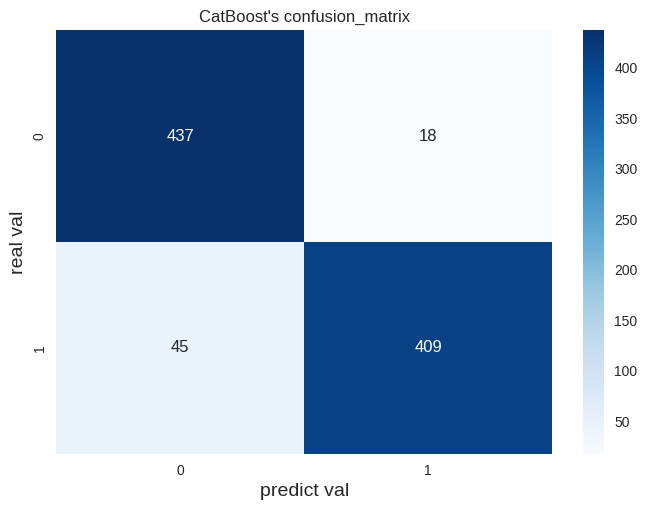

In [ ]:
# 혼동행렬 (가짜긍정 등등)
from sklearn.metrics import confusion_matrix


#모델 입력
#y_pred 우리 모델의 예측값
#y_true 정답/실제값

clf = grid.best_estimator_
y_pred = clf.predict(X_test)
y_true = y_test

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

#제목
plt.xlabel('predict val', fontsize=14)
plt.ylabel('real val', fontsize=14)
plt.title("CatBoost's confusion_matrix")

Text(0.5, 1.0, 'ROC Curve')

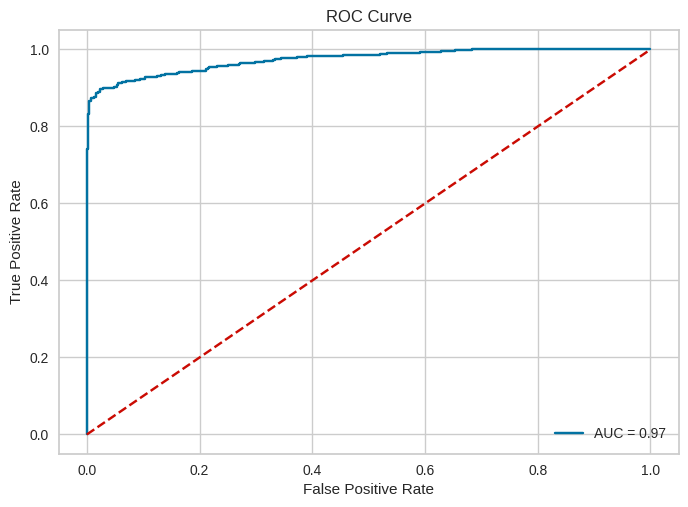

In [ ]:
#ROC 커브
from sklearn.metrics import roc_curve, roc_auc_score, auc

import matplotlib.pyplot as plt


y_probs = clf.predict_proba(X_test)[:, 1]

#fpr = False Positive Rate
#tpr = True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% auc(fpr, tpr))

#색상에 대한 설명
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

#x축 y축 제목
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

Text(0.5, 1.0, 'Precision-Recall Curve (AP=0.98)')

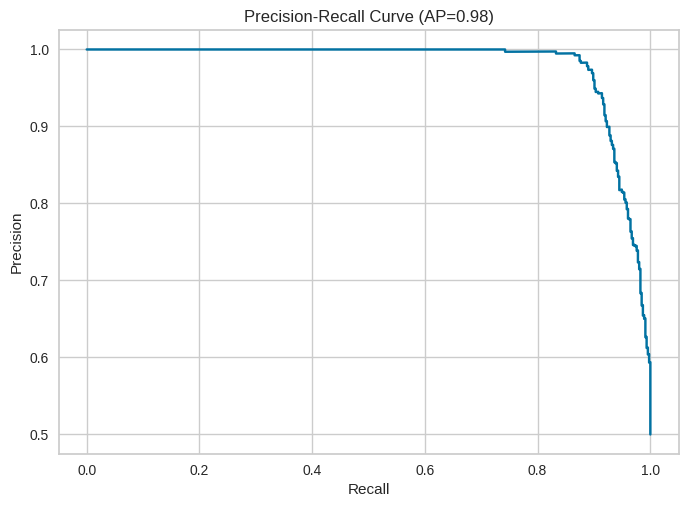

In [ ]:
#recall

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={average_precision:.2f})')

# 6.제출

In [ ]:
test.shape

(1119, 34)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1119 non-null   int64 
 1   Age                       1119 non-null   int64 
 2   BusinessTravel            1119 non-null   object
 3   DailyRate                 1119 non-null   int64 
 4   Department                1119 non-null   object
 5   DistanceFromHome          1119 non-null   int64 
 6   Education                 1119 non-null   int64 
 7   EducationField            1119 non-null   object
 8   EmployeeCount             1119 non-null   int64 
 9   EnvironmentSatisfaction   1119 non-null   int64 
 10  Gender                    1119 non-null   object
 11  HourlyRate                1119 non-null   int64 
 12  JobInvolvement            1119 non-null   int64 
 13  JobLevel                  1119 non-null   int64 
 14  JobRole                 

In [ ]:
train.shape, df.shape

((2665, 47), (3602, 48))

## train 데이터 병합

In [ ]:
from scipy import sparse

final_train_data_csr = sparse.hstack( [
    # 일반 => csr 변환
    sparse.csc_matrix(


        train[['Age', 'BusinessTravel', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsSinceLastPromotion']]  ),

       train[['Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single']]
], format='csr')

# 300000x16306 => 학습 진행
final_train_data_csr

<2665x44 sparse matrix of type '<class 'numpy.float64'>'
	with 61744 stored elements in Compressed Sparse Row format>

## test 데이터 전처리 및 병합

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#ds_copy = ds.copy()
df_col = [
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsSinceLastPromotion'
]

for col in df_col:
    test[col] = test[col].astype(float)
    test[[col]] = scaler.fit_transform(test[[col]])

#ds_copy.head()
test.nunique()

id                          1119
Age                           42
BusinessTravel                 3
DailyRate                    515
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        5
Gender                         2
HourlyRate                    71
JobInvolvement                 5
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome                726
MonthlyRate                  724
NumCompaniesWorked            11
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               5
TotalWorkingYears             38
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

In [ ]:
# test = test.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,0.660415,Research & Development,0.000000,0.00,Medical,1,1.00,...,1.000000,80,0.00,0.026316,0.333333,0.333333,0.027778,0,0.000000,0
1,1678,45,Travel_Rarely,0.756865,Sales,0.107143,0.75,Marketing,1,0.75,...,0.666667,80,0.25,0.184211,0.500000,0.666667,0.055556,2,0.133333,2
2,1679,37,Travel_Rarely,0.099799,Research & Development,0.428571,0.50,Life Sciences,1,1.00,...,0.333333,80,0.50,0.342105,0.333333,0.333333,0.194444,7,0.066667,7
3,1680,32,Travel_Rarely,0.456798,Research & Development,0.000000,0.75,Life Sciences,1,0.75,...,0.666667,80,0.00,0.368421,0.333333,0.333333,0.388889,10,0.733333,8
4,1681,29,Travel_Frequently,0.306765,Research & Development,0.285714,0.00,Life Sciences,1,0.75,...,0.000000,80,0.00,0.026316,0.833333,0.666667,0.027778,0,0.000000,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# 고유값이 2 또는 3인 컬럼 레이블 인코딩
test['BusinessTravel'] = encoder.fit_transform(test['BusinessTravel'])
test['Gender'] = encoder.fit_transform(test['Gender'])
test['OverTime'] = encoder.fit_transform(test['OverTime'])
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,0,0.660415,Research & Development,0.000000,0.00,Medical,1,1.00,...,1.000000,80,0.00,0.026316,0.333333,0.333333,0.027778,0,0.000000,0
1,1678,45,2,0.756865,Sales,0.107143,0.75,Marketing,1,0.75,...,0.666667,80,0.25,0.184211,0.500000,0.666667,0.055556,2,0.133333,2
2,1679,37,2,0.099799,Research & Development,0.428571,0.50,Life Sciences,1,1.00,...,0.333333,80,0.50,0.342105,0.333333,0.333333,0.194444,7,0.066667,7
3,1680,32,2,0.456798,Research & Development,0.000000,0.75,Life Sciences,1,0.75,...,0.666667,80,0.00,0.368421,0.333333,0.333333,0.388889,10,0.733333,8
4,1681,29,1,0.306765,Research & Development,0.285714,0.00,Life Sciences,1,0.75,...,0.000000,80,0.00,0.026316,0.833333,0.666667,0.027778,0,0.000000,0


In [ ]:
# 명목형 데이터는 원-핫 인코딩 진행
from sklearn.preprocessing import OneHotEncoder

# onehotencoder 선언
encoder = OneHotEncoder()

# 명목형 변수 추리기
categories = test[['Department', 'EducationField', 'JobRole', 'MaritalStatus']]

# 인코딩된 새로운 df생성
encoded_categories = encoder.fit_transform(categories)
encoded_test = pd.DataFrame(encoded_categories.toarray(), columns=encoder.get_feature_names_out(categories.columns))
encoded_test

,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1116,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1117,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
#shape비교
test.shape

(1119, 34)

In [ ]:
# 원본데이터에 인코딩 데이터 붙이기
test = test.reset_index()
encoded_test = encoded_test.reset_index()
con_test=pd.concat([test,encoded_test],axis=1)
print(con_test.shape)

#ds = con_ds
# 기존 명목변수 drop
test = con_test.drop(columns=['Department', 'EducationField', 'JobRole', 'MaritalStatus','index'])

test.info()

# ds ((2796, 35) /  encoded_ds (2796, 21)) / reset_index로 생긴 2개/ drop 4개와 + reset_index 2개/ (2796,52)

(1119, 57)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 1119 non-null   int64  
 1   Age                                1119 non-null   int64  
 2   BusinessTravel                     1119 non-null   int64  
 3   DailyRate                          1119 non-null   float64
 4   DistanceFromHome                   1119 non-null   float64
 5   Education                          1119 non-null   float64
 6   EmployeeCount                      1119 non-null   int64  
 7   EnvironmentSatisfaction            1119 non-null   float64
 8   Gender                             1119 non-null   int64  
 9   HourlyRate                         1119 non-null   float64
 10  JobInvolvement                     1119 non-null   float64
 11  JobLevel                           1119 non-n

In [ ]:
# test = test.drop(['JobLevel','YearsInCurrentRole', 'YearsWithCurrManager', 'id' ], axis=1)
test.shape

(1119, 47)

In [ ]:
test.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_R

In [ ]:
from scipy import sparse

final_test_data_csr = sparse.hstack( [
    # 일반 => csr 변환
    sparse.csc_matrix(


        test[['Age', 'BusinessTravel', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsSinceLastPromotion']]  ),

        test[['Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single']]
], format='csr')

# 300000x16306 => 학습 진행
final_test_data_csr

<1119x44 sparse matrix of type '<class 'numpy.float64'>'
	with 25679 stored elements in Compressed Sparse Row format>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                3602 non-null   int64  
 1   BusinessTravel                     3602 non-null   int64  
 2   DailyRate                          3602 non-null   float64
 3   DistanceFromHome                   3602 non-null   float64
 4   Education                          3602 non-null   float64
 5   EnvironmentSatisfaction            3602 non-null   float64
 6   Gender                             3602 non-null   int64  
 7   HourlyRate                         3602 non-null   float64
 8   JobInvolvement                     3602 non-null   float64
 9   JobLevel                           3602 non-null   float64
 10  JobSatisfaction                    3602 non-null   float64
 11  MonthlyIncome                      3602 non-null   float

In [ ]:
X = final_train_data_csr
y = df.Attrition[:2665]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

model = CatBoostClassifier(learning_rate=0.2, n_estimators=300, random_state=0, depth=2, grow_policy='Depthwise', min_child_samples=20)
model.fit(X_train, y_train)

0:	learn: 0.5704312	total: 5.88ms	remaining: 1.76s
1:	learn: 0.4958923	total: 10.5ms	remaining: 1.57s
2:	learn: 0.4445635	total: 14.2ms	remaining: 1.41s
3:	learn: 0.4151472	total: 17.4ms	remaining: 1.29s
4:	learn: 0.3914638	total: 20.5ms	remaining: 1.21s
5:	learn: 0.3799547	total: 23.5ms	remaining: 1.15s
6:	learn: 0.3685481	total: 26.6ms	remaining: 1.11s
7:	learn: 0.3599119	total: 29.8ms	remaining: 1.09s
8:	learn: 0.3521681	total: 32.9ms	remaining: 1.06s
9:	learn: 0.3472191	total: 36.1ms	remaining: 1.04s
10:	learn: 0.3430366	total: 39ms	remaining: 1.02s
11:	learn: 0.3399208	total: 42.3ms	remaining: 1.01s
12:	learn: 0.3357660	total: 45.3ms	remaining: 1s
13:	learn: 0.3319429	total: 48.5ms	remaining: 991ms
14:	learn: 0.3278383	total: 51.6ms	remaining: 981ms
15:	learn: 0.3249292	total: 54.6ms	remaining: 969ms
16:	learn: 0.3235109	total: 57.5ms	remaining: 957ms
17:	learn: 0.3214426	total: 60.3ms	remaining: 944ms
18:	learn: 0.3192893	total: 63.3ms	remaining: 936ms
19:	learn: 0.3173858	total:

## 최종 제출

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/머신러닝/ASAC project/모델링/sample_submission.csv')
submission.head()

,id,Attrition
0,1677,0.119261
1,1678,0.119261
2,1679,0.119261
3,1680,0.119261
4,1681,0.119261


In [ ]:
# 제출용 데이터를 기반으로 예측, 제출파일 생성
y_pred_submission    = model.predict_proba( final_test_data_csr )[:,1]
submission['Attrition'] = y_pred_submission
submission.to_csv( 'my_submission_v1.csv', index=False )

## 제출 사이트 및 점수 결과
- https://www.kaggle.com/competitions/playground-series-s3e3
- 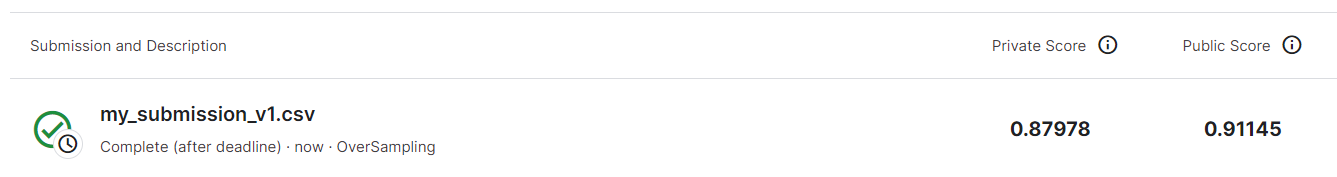